In [1]:
from itertools import product
from collections import deque
import numpy as np

In [4]:
%load_ext autoreload
%autoreload 2
from ca_utils import get_lookup_indicies, get_binary_rule_rep, get_kmers, process_inpt

# 1- Binary 1-D Cellular Automata

This notebook will cover:
- Basics of CAs as indexing functions
- Implementation of 1D CAs
- Generation of CA update map based ona randomly chosen rule & input sequence

## a) Defining A closed set of CA rules and identifying a singular rule

Cellular automata rules come in sets. To define this set, two elements are required:
1. A set of discreet states
2. A rule order

A set of CA rules is defined as all the CA rule sequences that are of a specific length and consistent of all the possible permutations of these discreet states of that length.

The length of the CA rule sequence is defined as the number of permutatons of sequeneces of the discreet states that are rule order in length.

for example, lets define the following:
    - states:  S = [0, 1]
    - rule order O = 3
    
Thus the set permutations of these states that are 3 in length are ['000', '001', '010', '011', '100', '101', '110', '111'].

Note: There is an implicit order here, and That is by choice of how we ordered the permutations. The order does not necissairaly matter so long as it is explicitly stated and carried through. In this case, the order used will be the one expressed above.

The count of these permutations is 8. This can be simple expressed as:
    
    L(R) = L(S) ^ O where,
        R : any CA Rule within the CA rule set
        L(R) : sequence length of any rule in the CA rule set
        S : set of states
        L(S) : length of the set of states
        O : rule order
        
To total size (i.e. magnitude) of the CA rule set can then be calculated by counting all the possible permutations of the states that are of L(R) long. i.e.
    
    |R| = L(S) ^ L(R)
    or 
    |R| = L(S) ^ (L(S) ^ O)
    
In the case above, substituting for L(S) = 2, O = 3, we get |R| = 256.

So in short, for S = [0, 1] & O = 2, we have defined a set of 256 CA rules (that are all the 8-long permutation sequences of the states in S). examples are: '01001101', '01001101', '11110000', ...

Similarly, we have defined as way to access the specific states of any given rule defined in this set but using the ordered set of indicies (permutations of states in S of length )) -> ['000', '001', '010', '011', '100', '101', '110', '111'].

We can also order the set of CA rules by numbering them. The most trivial way of doing this is by converting the CA rule sequence from the binary representation into an integer. For example: 

    '00000000' = 0
    '00100001' = 33
    '10001001' = 137
    '11110110' = 246
    
So in conclusion, Any CA Rule has this form, where S1...S8 are all one of [0, 1], and specific rules 33, 137 & 212 are:

| Indicies 	| Rule Set 	| Rule 33 	| Rule 137 	| rule 212 	|
|:--------:	|:--------:	|:-------:	|:--------:	|:--------:	|
|    000   	|    S1    	|    0    	|     1    	|     1    	|
|    001   	|    S2    	|    0    	|     0    	|     1    	|
|    010   	|    S3    	|    1    	|     0    	|     0    	|
|    011   	|    S4    	|    0    	|     0    	|     1    	|
|    100   	|    S5    	|    0    	|     1    	|     0    	|
|    101   	|    S6    	|    0    	|     0    	|     1    	|
|    110   	|    S7    	|    0    	|     0    	|     0    	|
|    111   	|    S8    	|    1    	|     1    	|     0    	|


As such, Cellular Automata rules, can be viewed as indexing functions, where the input is a specific permutation of its possible indicies, and the output is the corresponding state

This would be the same as saying:
    
    Rule(index) = state.
    
Note that the only valid indicies are the ones that are of length of O and consist of only states '0' or '1'

so the process here is simple:
    
    - take an input, say '101', and a rule say # 212.
    - convert the input to teh appropriate index, in this case 6
    - covert the rul into the bibary rep, in this case '11010100'
    - return the 6th state of the binary rule rep, in this case 1
    
And this is the basis of a CA rule indexing.

The same process can be extended to any arbitrary length input so long as it is longer that O. This is done by breaking the input in consecutive [k-mers](https://en.wikipedia.org/wiki/K-mer), and repeating the indexing process. this can be done as follows:

    - for input '101100101', the corresponding kmers would be: 101 011 110 100 001 010 101
    - same as above, the output for the rule 212 would be: 1 1 0 0 1 0 1
    
consquently, k-mers can be looped around the ends of the input sequence, like a taurus. this would make the number of output states equal to the number of states in the input sequence.

    - for input '101100101', the corresponding kmers would be: 110 101 011 110 100 001 010 101 011
    - same as above, the output for the rule 212 would be: 0 1 1 0 0 1 0 1 1

To implement this, a few functions are needed:
1. get_lookup_indicies: defines a apping of the ordered indices and the corresponding index in a specific rule sequence
2. get_binary_rule_rep: converts a rule number into its binary representation
3. get kmers: converts an input sequence into a set of kmers
4. process input: process an input sequence through a given rule using the 3 functions above.

|     index    	| 000 	| 001 	| 010 	| 011 	| 100 	| 101 	| 110 	| 111 	|
|:------------:	|:---:	|:---:	|:---:	|:---:	|-----	|-----	|-----	|-----	|
| index number 	|  0  	|  1  	|  2  	|  3  	| 4   	| 5   	| 6   	| 7   	|
| Rule 212     	| 1   	| 1   	| 0   	| 1   	| 0   	| 1   	| 0   	| 0   	|


|non-looping  k-mer	| 101 	| 011 	| 110 	| 100 	| 001 	| 010 	| 101 	|
|:---------------:	|:---:	|:---:	|:---:	|:---:	|-----	|-----	|-----	|
| Rule 212 output 	|  1  	|  1  	|  0  	|  0  	| 1   	| 1   	| 1   	|

| looping k-mers  	| 110 	| 101 	| 011 	| 110 	| 100 	| 001 	| 010 	| 101 	| 011 	|
|:---------------:	|-----	|:---:	|:---:	|:---:	|:---:	|-----	|-----	|-----	|-----	|
| Rule 212 output 	| 0   	|  1  	|  1  	|  0  	|  0  	| 1   	| 1   	| 1   	| 1   	|



In [4]:
def get_lookup_indicies(inpt_states, order):
    '''
    Get lookup indicies for the set of CA Rules defined by the input_states & a specific rule order
    '''
    return {''.join(inpt): idx for idx, inpt in enumerate(product(ca_states, repeat=order))}

ca_states = '01'
rule_orders = [1,2,3]

for rule_order in rule_orders:
    rule_indicies = get_lookup_indicies(ca_states, rule_order)
    print(f'For states {ca_states} & a rule order (Neighbourhood Size) = {rule_order},\
          \nthe fixed CA rule lookup indicies are:\n{rule_indicies}\n')

For states 01 & a rule order (Neighbourhood Size) = 1,          
the fixed CA rule lookup indicies are:
{'0': 0, '1': 1}

For states 01 & a rule order (Neighbourhood Size) = 2,          
the fixed CA rule lookup indicies are:
{'00': 0, '01': 1, '10': 2, '11': 3}

For states 01 & a rule order (Neighbourhood Size) = 3,          
the fixed CA rule lookup indicies are:
{'000': 0, '001': 1, '010': 2, '011': 3, '100': 4, '101': 5, '110': 6, '111': 7}



What this tells us, that a CA rule space is all the possible rules that are consistent of strings equal in length to the indicies map defined above, and the states.

For example, for states [0,1], and rule order = 3, we have 2^3 = 8 possible indicies. So any rule will be the 8-long combination of states [0,1]. eg. 10010110, or 01001001.

For simplicity, we can convert the binary representations above into integers and that is how we get rule numbers:

eg:

- b10010110 = 150
- b01001001 =  73

to simplify lets make a a function to convert an int into a binary rep

In [381]:
def get_bin(rule_number, rule_order):
    ''' Get the correctly justified binary representation of a CA rule based on the rule order
    note: only works for binary states [0,1]. will be genralized in a later workbook'''
    base = 2
    rule_length = base ** rule_order
    rule_count = base ** rule_length
    
    assert rule_number < rule_count, f'For rule order = {rule_order} & states = [0, 1], rule_number must be [0,{rule_count})'
    rule_rep = bin(rule_number)[2:]
    rule_rep = rule_rep.rjust(rule_length, '0')
    return rule_rep

In [382]:
get_bin(33, 2)

AssertionError: For rule order = 2 & states = [0, 1], rule_number must be [0,16)

At this point, we've defined the set of CA rules, and a specific rule in that set (eg. rule 33 = '00100001')
The next step is to define an indexing opperation.

This is simply an indexing function:
    - for a given rule number get the rule representation
    - for the given input, get the indexed output

In [29]:
def process(inpt, rule_number, inpt_states='01', rule_order=3):
    #get rule representation
    rule_rep = get_bin(rule_number=rule_number, rule_order=rule_order)
    print(f'\nThe representation for rule # {rule_number} is {rule_rep}')
    
    lookup_indicies = get_lookup_indicies(inpt_states=inpt_states, order=rule_order)
    print(f'\nThe Indicies for states: {inpt_states} and rule order = {rule_order} are: \n{lookup_indicies}')
          
    output_index = lookup_indicies[inpt]
    output_state = rule_rep[output_index]
    
    return output_state

In [43]:
inpt = '010'
rule_number = np.random.randint(256)
output = process(inpt = inpt, rule_number=rule_number)
print(f'\nThe result of processing input: {inpt} through rule number {rule_number} is: {output}')


The representation for rule # 77 is 01001101

The Indicies for states: 01 and rule order = 3 are: 
{'000': 0, '001': 1, '010': 2, '011': 3, '100': 4, '101': 5, '110': 6, '111': 7}

The result of processing input: 010 through rule number 77 is: 0


In the case above, the input length was chosen to be equal to the rule order (3). This does not have to be the case, we can have any length input so long as it is longer than the rule order.

To do this, we wil simply take the input and break it into k-mers (in this case k=3) and then sequentially run them through the CA rule. eg. input '1010011010' would be the consecutive outputs of ['101', '010', '100', '001', '011', '110', '101', '010']

note: there is not wrap around implemented here. the kmers are a rolling window of length k indexed on the itteration number from right to left. this means that the length of the output of any input processed thsi way will be qual to:
    
    len(output) = len(input) - o + 1 (where o = rule order)

In [385]:
def get_kmers(inpt, k=5, looping=False):
    if looping:
        inpt_length = len(inpt)
        inpt = deque(inpt)
        init_rotations = int(np.floor((k-1)/2))
        inpt.rotate(init_rotations)
        
        kmers = []
        for _ in range(inpt_length):
            kmers.append(list(inpt)[:k])
            inpt.rotate(-1)
    else:
        kmers = zip(*[inpt[idx:] for idx in range(k)])
    kmers = [''.join(kmer) for kmer in kmers]
    return kmers

print(f"non-looping k-mers (k=3) for input = 1010011010 are:\n{get_kmers('1010011010')}")
print(f"\nlooping k-mers (k=3) for input = 1010011010 are:\n{get_kmers('1010011010',looping=True)}")

non-looping k-mers (k=3) for input = 1010011010 are:
['10100', '01001', '10011', '00110', '01101', '11010']

looping k-mers (k=3) for input = 1010011010 are:
['10101', '01010', '10100', '01001', '10011', '00110', '01101', '11010', '10101', '01010']


In [78]:
def process(inpt, rule_number, inpt_states='01', rule_order=3, looping=True):
    #get rule representation
    rule_rep = get_bin(rule_number=rule_number, rule_order=rule_order)
    
    kmers = get_kmers(inpt=inpt, k=rule_order, looping=looping)
    
    lookup_indicies = get_lookup_indicies(inpt_states=inpt_states, order=rule_order)
          
    output_indicies = [lookup_indicies[kmer] for kmer in kmers]
    output= ''.join([rule_rep[idx] for idx in output_indicies])
    
    return output

inpt = '101'
output = process(inpt = inpt, rule_number=rule_number)
print(f'\nThe result of processing input: {inpt} through rule number {rule_number} is: {output}')

inpt = '1010011010'
output = process(inpt = inpt, rule_number=rule_number)
print(f'\nThe result of processing input: {inpt} through rule number {rule_number} is: {output}')


The result of processing input: 101 through rule number 77 is: 010

The result of processing input: 1010011010 through rule number 77 is: 0101100101


In [376]:
random_rule = np.random.randint(255)
random_inpt = ''.join(np.random.choice(list('01'), size=2048, p=[0.55, 0.45]))

results = [random_inpt]
for _ in range(2048):
    results.append(process(results[-1], rule_number=random_rule))

color_map = {'0':[65, 102, 245], '1':[255, 174, 66]}
results = [[color_map[val] for val in result] for result in results]

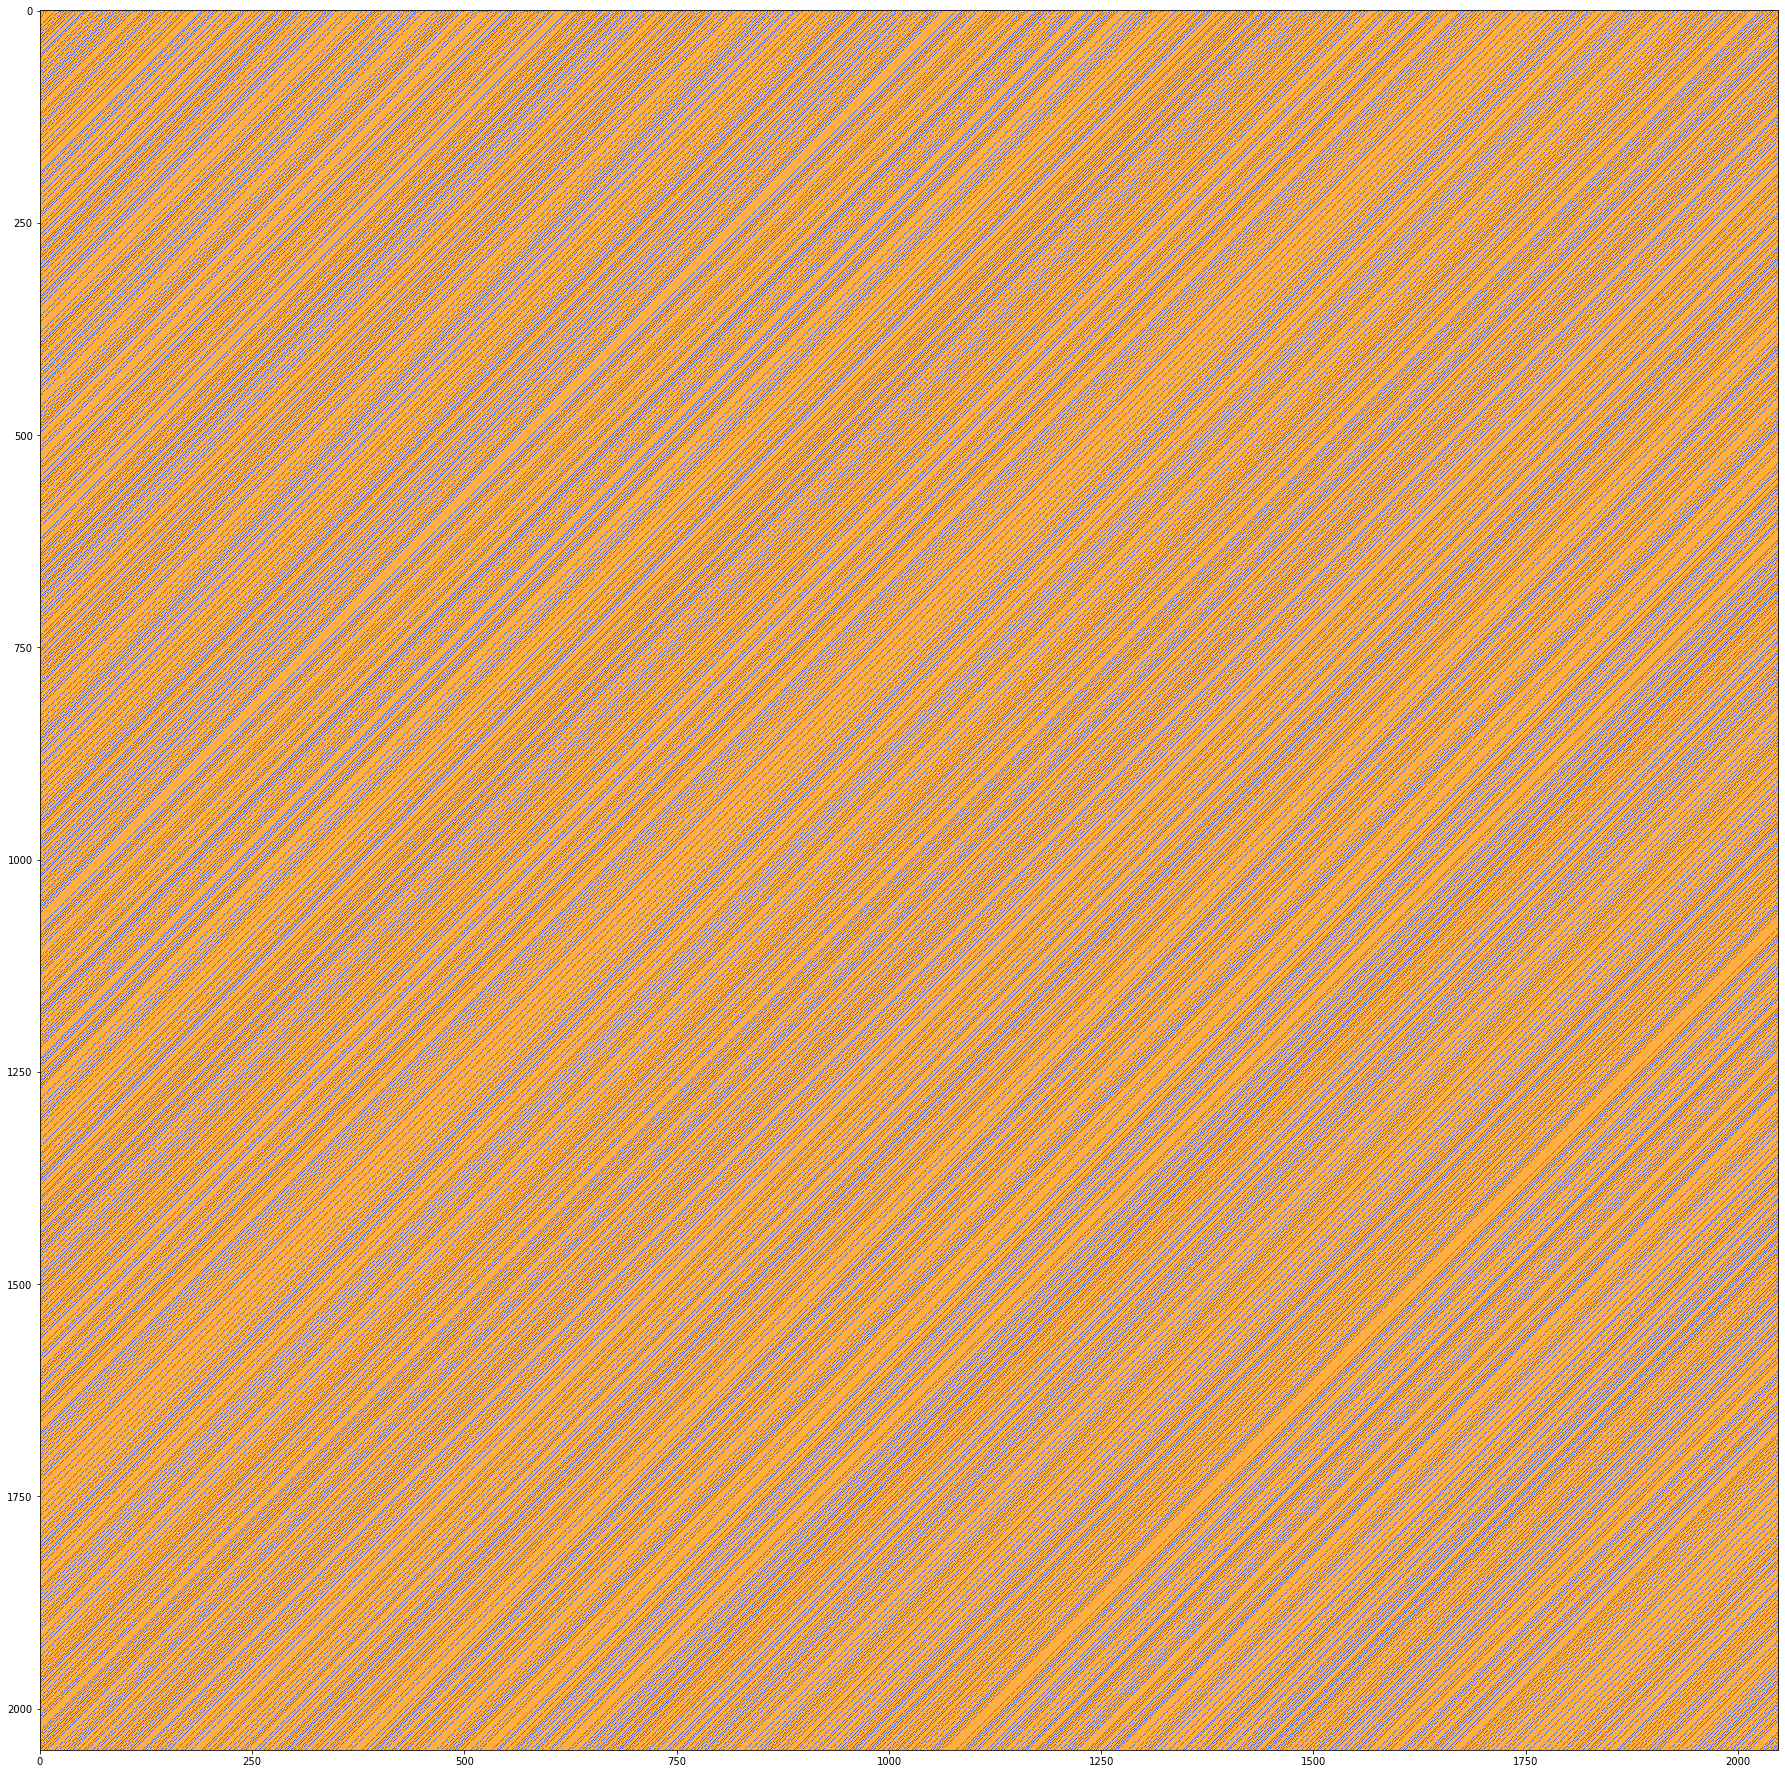

In [377]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32,32))
plt.imshow(results)
plt.savefig('Christina likes this one.jpg')

In [366]:
plt.savefig('Christina likes this one.jpg')

<Figure size 432x288 with 0 Axes>